In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("HopworkData.csv")
df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     168 non-null    int64         
 1   timestamp_int  168 non-null    int64         
 2   timestamp_utc  168 non-null    datetime64[ns]
 3   latitude       168 non-null    float64       
 4   longitude      168 non-null    float64       
 5   aqi            168 non-null    int64         
 6   co             168 non-null    float64       
 7   no2            168 non-null    float64       
 8   o3             168 non-null    float64       
 9   so2            168 non-null    float64       
 10  pm2_5          168 non-null    float64       
 11  pm10           168 non-null    float64       
 12  temp           168 non-null    float64       
 13  feels_like     0 non-null      float64       
 14  pressure       168 non-null    int64         
 15  humidity       168 non-

In [4]:
df.describe()

,Unnamed: 0,timestamp_int,timestamp_utc,latitude,longitude,aqi,co,no2,o3,so2,pm2_5,pm10,temp,feels_like,pressure,humidity,wind_speed,clouds
count,168.000000,1.680000e+02,168,1.680000e+02,1.680000e+02,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,0.0,168.000000,168.000000,168.000000,168.000000
mean,83.500000,1.758937e+09,2025-09-27 01:30:00.000000256,2.486070e+01,6.700110e+01,2.059524,90.103095,0.065119,47.406964,0.307381,8.700476,37.522619,29.614286,NaN,1005.017857,68.244048,3.610298,49.755952
min,0.000000,1.758636e+09,2025-09-23 14:00:00,2.486070e+01,6.700110e+01,1.000000,82.720000,0.030000,39.000000,0.060000,2.930000,9.990000,24.900000,NaN,998.000000,23.000000,0.000000,5.000000
25%,41.750000,1.758786e+09,2025-09-25 07:45:00,2.486070e+01,6.700110e+01,2.000000,89.347500,0.040000,45.335000,0.110000,6.345000,22.550000,26.900000,NaN,1003.000000,58.000000,2.570000,20.750000
50%,83.500000,1.758937e+09,2025-09-27 01:30:00,2.486070e+01,6.700110e+01,2.000000,90.925000,0.060000,47.805000,0.280000,7.420000,28.950000,28.900000,NaN,1005.000000,76.000000,3.600000,40.000000
75%,125.250000,1.759087e+09,2025-09-28 19:15:00,2.486070e+01,6.700110e+01,2.000000,91.642500,0.070000,49.752500,0.470000,10.102500,49.160000,30.900000,NaN,1007.000000,83.000000,4.630000,75.000000
max,167.000000,1.759237e+09,2025-09-30 13:00:00,2.486070e+01,6.700110e+01,3.000000,100.430000,0.430000,59.990000,0.770000,21.440000,87.570000,37.900000,NaN,1010.000000,94.000000,11.830000,100.000000
std,48.641546,1.751096e+05,NaN,3.563335e-15,1.425334e-14,0.653891,2.897401,0.043154,4.268047,0.206114,4.083389,21.840034,3.326797,NaN,2.943527,17.970534,1.592503,27.742291


In [5]:
df.head()

,Unnamed: 0,timestamp_int,timestamp_utc,latitude,longitude,aqi,co,no2,o3,so2,pm2_5,pm10,temp,feels_like,pressure,humidity,wind_speed,clouds
0,0,1758636000,2025-09-23 14:00:00,24.8607,67.0011,1,87.00,0.07,41.31,0.28,2.93,9.99,27.9,NaN,1006,69,5.14,75
1,1,1758639600,2025-09-23 15:00:00,24.8607,67.0011,1,86.69,0.07,41.05,0.29,3.10,10.70,26.9,NaN,1006,78,4.63,40
2,2,1758643200,2025-09-23 16:00:00,24.8607,67.0011,1,86.02,0.07,40.53,0.30,3.27,11.33,26.9,NaN,1007,78,4.12,40
3,3,1758646800,2025-09-23 17:00:00,24.8607,67.0011,1,85.53,0.07,40.09,0.31,3.44,11.94,26.9,NaN,1007,78,4.63,40
4,4,1758650400,2025-09-23 18:00:00,24.8607,67.0011,1,85.01,0.07,39.62,0.32,3.63,12.61,26.9,NaN,1007,78,5.66,40


## To calculate AQI number

### The Logic 🧠

 - **Calculate an Individual Score:** You don't combine the pollutant values directly. Instead, you calculate a separate AQI score for each pollutant (PM2.5, O3, CO, etc.) using a standard formula and breakpoint tables. These tables define what concentration of a pollutant corresponds to a specific AQI range (Good, Moderate, Unhealthy, etc.).

 - **Find the Maximum:** The final, overall AQI for that specific time is simply the highest individual score among all the pollutants you calculated. The pollutant that produces this highest score is called the "primary" or "dominant" pollutant

In [6]:
MW = {
    'co': 28.01,
    'o3': 48.00,
    'no2': 46.01,
    'so2': 64.07,
}

# EPA AQI Breakpoints (updated as of 2024)
# Format: (Breakpoint Low, Breakpoint High), (AQI Low, AQI High)
BREAKPOINTS = {
    'co': [ # Unit: ppm (8-hr)
        ((0.0, 4.4), (0, 50)),
        ((4.5, 9.4), (51, 100)),
        ((9.5, 12.4), (101, 150)),
        ((12.5, 15.4), (151, 200)),
        ((15.5, 30.4), (201, 300)),
        ((30.5, 40.4), (301, 400)),
        ((40.5, 50.4), (401, 500)),
    ],
    'no2': [ # Unit: ppb (1-hr)
        ((0, 53), (0, 50)),
        ((54, 100), (51, 100)),
        ((101, 360), (101, 150)),
        ((361, 649), (151, 200)),
        ((650, 1249), (201, 300)),
        ((1250, 1649), (301, 400)),
        ((1650, 2049), (401, 500)),
    ],
    'o3': [ # Unit: ppb (8-hr)
        ((0, 54), (0, 50)),
        ((55, 70), (51, 100)),
        ((71, 85), (101, 150)),
        ((86, 105), (151, 200)),
        ((106, 200), (201, 300)),
        # Note: 8-hr Ozone AQI is not defined above 200 ppb
    ],
    'so2': [ # Unit: ppb (1-hr)
        ((0, 35), (0, 50)),
        ((36, 75), (51, 100)),
        ((76, 185), (101, 150)),
        ((186, 304), (151, 200)),
        ((305, 604), (201, 300)),
        ((605, 804), (301, 400)),
        ((805, 1004), (401, 500)),
    ],
    'pm2_5': [ # Unit: µg/m³ (24-hr)
        ((0.0, 9.0), (0, 50)),
        ((9.1, 35.4), (51, 100)),
        ((35.5, 55.4), (101, 150)),
        ((55.5, 150.4), (151, 200)),
        ((150.5, 250.4), (201, 300)),
        ((250.5, 350.4), (301, 400)),
        ((350.5, 500.4), (401, 500)),
    ],
    'pm10': [ # Unit: µg/m³ (24-hr)
        ((0, 54), (0, 50)),
        ((55, 154), (51, 100)),
        ((155, 254), (101, 150)),
        ((255, 354), (151, 200)),
        ((355, 424), (201, 300)),
        ((425, 504), (301, 400)),
        ((505, 604), (401, 500)),
    ],
}


# --- 2. Unit Conversion Functions ---

def ugm3_to_ppb(ugm3, pollutant_name):
    """Converts concentration from µg/m³ to ppb at standard conditions (25°C, 1 atm)."""
    if pollutant_name not in MW:
        return ugm3
    molecular_weight = MW[pollutant_name]
    # Molar volume at 25°C, 1 atm is 24.45 L/mol
    # Conversion: ppb = (µg/m³ * 24.45) / MolecularWeight
    return (ugm3 * 24.45) / molecular_weight

def ugm3_to_ppm(ugm3, pollutant_name):
    """Converts concentration from µg/m³ to ppm."""
    # 1 ppm = 1000 ppb
    return ugm3_to_ppb(ugm3, pollutant_name) / 1000


# --- 3. Core AQI Calculation Functions ---

def calculate_sub_index(conc, pollutant):
    """Calculates the AQI sub-index for a single pollutant."""
    
    # 1. Truncate and convert concentration to correct units
    if pollutant == 'pm2_5':
        conc = np.floor(conc * 10) / 10  # Truncate to 1 decimal
    elif pollutant == 'pm10':
        conc = np.floor(conc) # Truncate to integer
    elif pollutant == 'co':
        conc = np.floor(ugm3_to_ppm(conc, pollutant) * 10) / 10 # Truncate to 1 decimal
    elif pollutant in ['no2', 'o3', 'so2']:
        conc = np.floor(ugm3_to_ppb(conc, pollutant)) # Truncate to integer
    else:
        return np.nan # Pollutant not supported
        
    # 2. Find the correct concentration range in the breakpoints table
    for (conc_low, conc_high), (aqi_low, aqi_high) in BREAKPOINTS[pollutant]:
        if conc_low <= conc <= conc_high:
            # 3. Apply the linear interpolation formula
            # AQI = ((AQI_high - AQI_low) / (Conc_high - Conc_low)) * (Conc - Conc_low) + AQI_low
            aqi = ((aqi_high - aqi_low) / (conc_high - conc_low)) * (conc - conc_low) + aqi_low
            return round(aqi)
            
    # Handle concentrations that are "off the charts" (above 500)
    if conc > BREAKPOINTS[pollutant][-1][0][1]:
        return 500
    
    return np.nan # Should not happen if data is valid

def calculate_overall_aqi(row):
    """
    Calculates the final AQI from a row of pollutant data (in µg/m³).
    The final AQI is the *maximum* of all individual sub-indices.
    """
    pollutants = ['pm2_5', 'pm10', 'o3', 'co', 'no2', 'so2']
    sub_indices = []
    
    for p in pollutants:
        if p in row:
            sub_index = calculate_sub_index(row[p], p)
            if pd.notna(sub_index):
                sub_indices.append(sub_index)
    
    # Return the highest sub-index, or NaN if no valid data
    return max(sub_indices) if sub_indices else np.nan


# 2. Apply the AQI calculation to each row in the DataFrame
# The .apply() method runs our function on every single row
df['calculated_aqi'] = df.apply(calculate_overall_aqi, axis=1)


# 3. Display the results


In [7]:
df['calculated_aqi'] = df.apply(calculate_overall_aqi, axis=1)


In [8]:
df.tail()

,Unnamed: 0,timestamp_int,timestamp_utc,latitude,longitude,aqi,co,no2,o3,so2,pm2_5,pm10,temp,feels_like,pressure,humidity,wind_speed,clouds,calculated_aqi
163,163,1759222800,2025-09-30 09:00:00,24.8607,67.0011,3,93.35,0.06,54.58,0.47,19.30,83.81,35.9,NaN,999,41,5.66,40,70
164,164,1759226400,2025-09-30 10:00:00,24.8607,67.0011,3,93.95,0.06,55.68,0.47,20.02,86.52,36.9,NaN,998,39,7.20,40,71
165,165,1759230000,2025-09-30 11:00:00,24.8607,67.0011,3,94.54,0.07,57.24,0.46,20.72,87.57,35.9,NaN,998,44,5.14,40,73
166,166,1759233600,2025-09-30 12:00:00,24.8607,67.0011,3,95.22,0.09,58.87,0.47,21.18,87.26,32.9,NaN,998,55,11.83,75,73
167,167,1759237200,2025-09-30 13:00:00,24.8607,67.0011,3,95.97,0.11,59.99,0.48,21.44,86.40,28.9,NaN,999,79,4.12,100,74


In [9]:
df.describe()

,Unnamed: 0,timestamp_int,timestamp_utc,latitude,longitude,aqi,co,no2,o3,so2,pm2_5,pm10,temp,feels_like,pressure,humidity,wind_speed,clouds,calculated_aqi
count,168.000000,1.680000e+02,168,1.680000e+02,1.680000e+02,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,0.0,168.000000,168.000000,168.000000,168.000000,168.000000
mean,83.500000,1.758937e+09,2025-09-27 01:30:00.000000256,2.486070e+01,6.700110e+01,2.059524,90.103095,0.065119,47.406964,0.307381,8.700476,37.522619,29.614286,NaN,1005.017857,68.244048,3.610298,49.755952,43.077381
min,0.000000,1.758636e+09,2025-09-23 14:00:00,2.486070e+01,6.700110e+01,1.000000,82.720000,0.030000,39.000000,0.060000,2.930000,9.990000,24.900000,NaN,998.000000,23.000000,0.000000,5.000000,19.000000
25%,41.750000,1.758786e+09,2025-09-25 07:45:00,2.486070e+01,6.700110e+01,2.000000,89.347500,0.040000,45.335000,0.110000,6.345000,22.550000,26.900000,NaN,1003.000000,58.000000,2.570000,20.750000,35.000000
50%,83.500000,1.758937e+09,2025-09-27 01:30:00,2.486070e+01,6.700110e+01,2.000000,90.925000,0.060000,47.805000,0.280000,7.420000,28.950000,28.900000,NaN,1005.000000,76.000000,3.600000,40.000000,41.000000
75%,125.250000,1.759087e+09,2025-09-28 19:15:00,2.486070e+01,6.700110e+01,2.000000,91.642500,0.070000,49.752500,0.470000,10.102500,49.160000,30.900000,NaN,1007.000000,83.000000,4.630000,75.000000,53.000000
max,167.000000,1.759237e+09,2025-09-30 13:00:00,2.486070e+01,6.700110e+01,3.000000,100.430000,0.430000,59.990000,0.770000,21.440000,87.570000,37.900000,NaN,1010.000000,94.000000,11.830000,100.000000,74.000000
std,48.641546,1.751096e+05,NaN,3.563335e-15,1.425334e-14,0.653891,2.897401,0.043154,4.268047,0.206114,4.083389,21.840034,3.326797,NaN,2.943527,17.970534,1.592503,27.742291,13.771878


## Graphs

In [10]:
# Define which pollutants to plot
pollutants_to_plot = ['pm2_5', 'pm10', 'o3', 'co']
    
# Set plot style
sns.set_style("whitegrid")

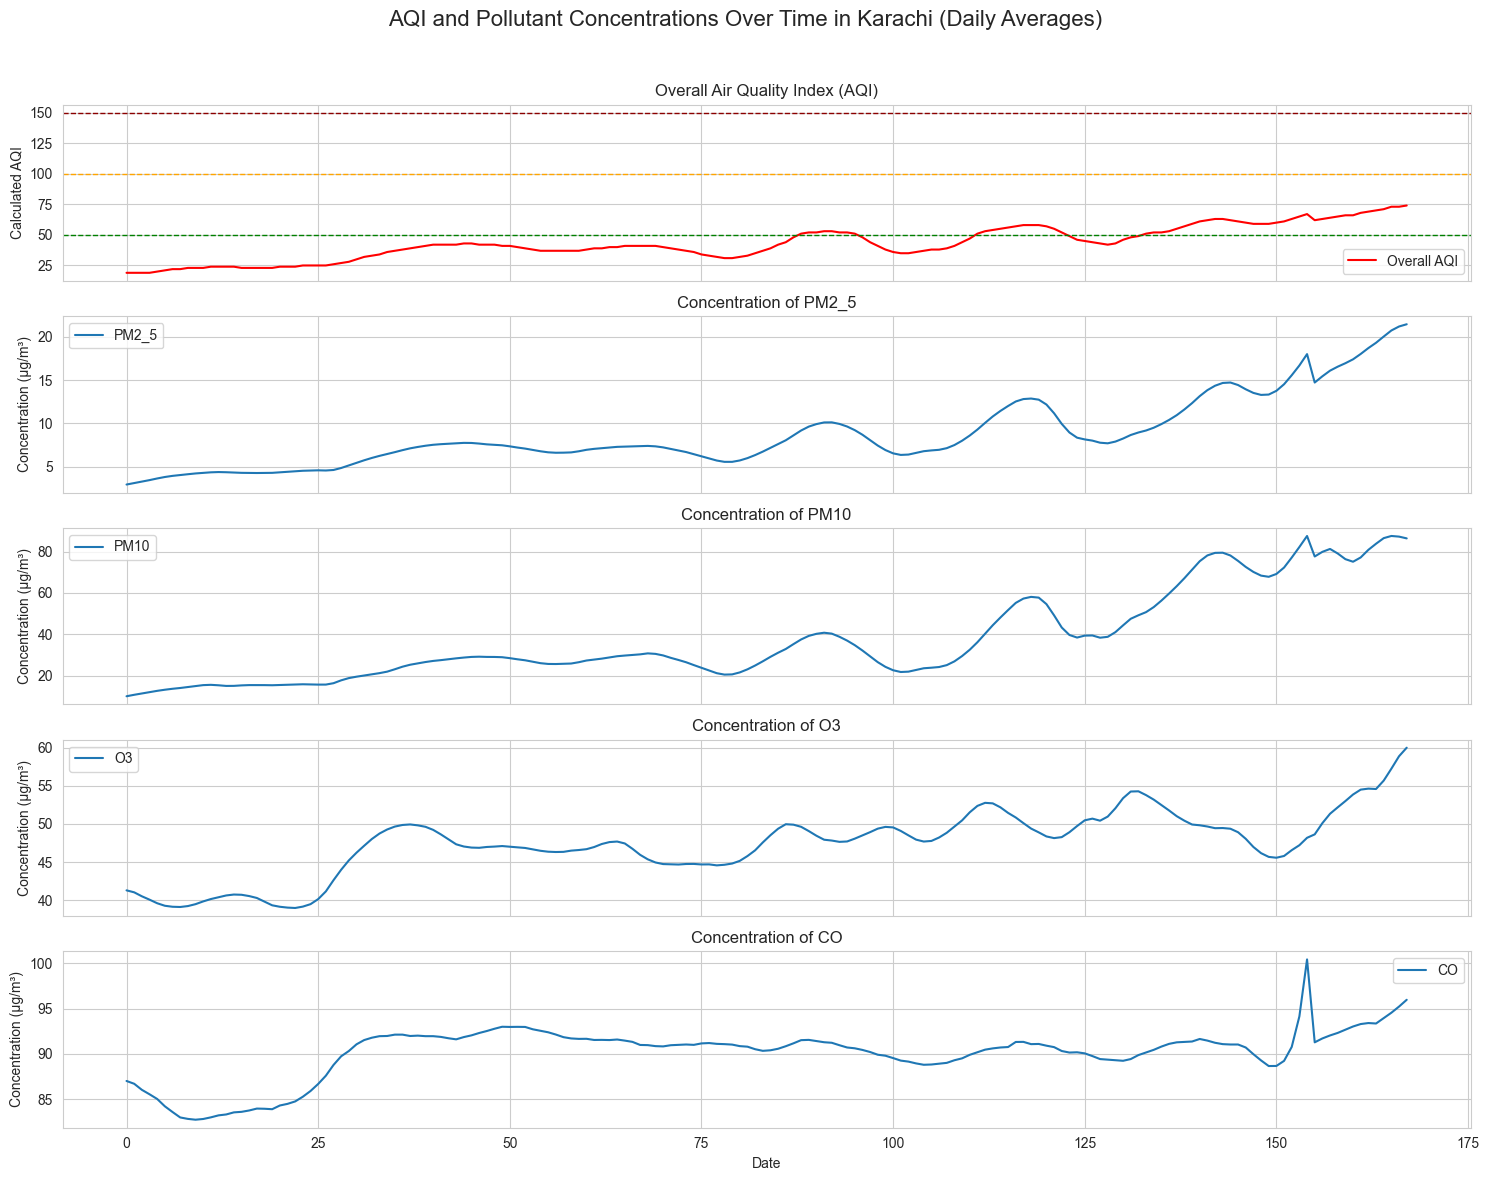

In [11]:
# Create subplots. The number of rows is 1 (for AQI) + the number of pollutants.
    # `sharex=True` links the x-axes, so zooming in one plot zooms all.
fig, axes = plt.subplots(len(pollutants_to_plot) + 1, 1, figsize=(15, 12), sharex=True)
    
    # Main Title for the entire figure
fig.suptitle('AQI and Pollutant Concentrations Over Time in Karachi (Daily Averages)', fontsize=16)

    # 1. Plot Calculated AQI
axes[0].plot(df.index, df['calculated_aqi'], color='red', label='Overall AQI')
axes[0].set_ylabel('Calculated AQI')
axes[0].set_title('Overall Air Quality Index (AQI)')
axes[0].legend()
    # Add horizontal lines for AQI categories for context
axes[0].axhline(50, color='green', linestyle='--', linewidth=1, label='Good')
axes[0].axhline(100, color='orange', linestyle='--', linewidth=1, label='Moderate')
axes[0].axhline(150, color='darkred', linestyle='--', linewidth=1, label='Unhealthy (Sensitive)')

# 2. Plot Each Pollutant on its own subplot
for i, pollutant in enumerate(pollutants_to_plot):
    ax = axes[i + 1]
    ax.plot(df.index, df[pollutant], label=pollutant.upper())
    ax.set_ylabel(f'Concentration (µg/m³)')
    ax.set_title(f'Concentration of {pollutant.upper()}')
    ax.legend()
        
    # Improve layout and show the plot
plt.xlabel('Date')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

In [12]:
print("Engineering time features...")
df['hour_of_day'] = df['timestamp_utc'].dt.hour

Engineering time features...


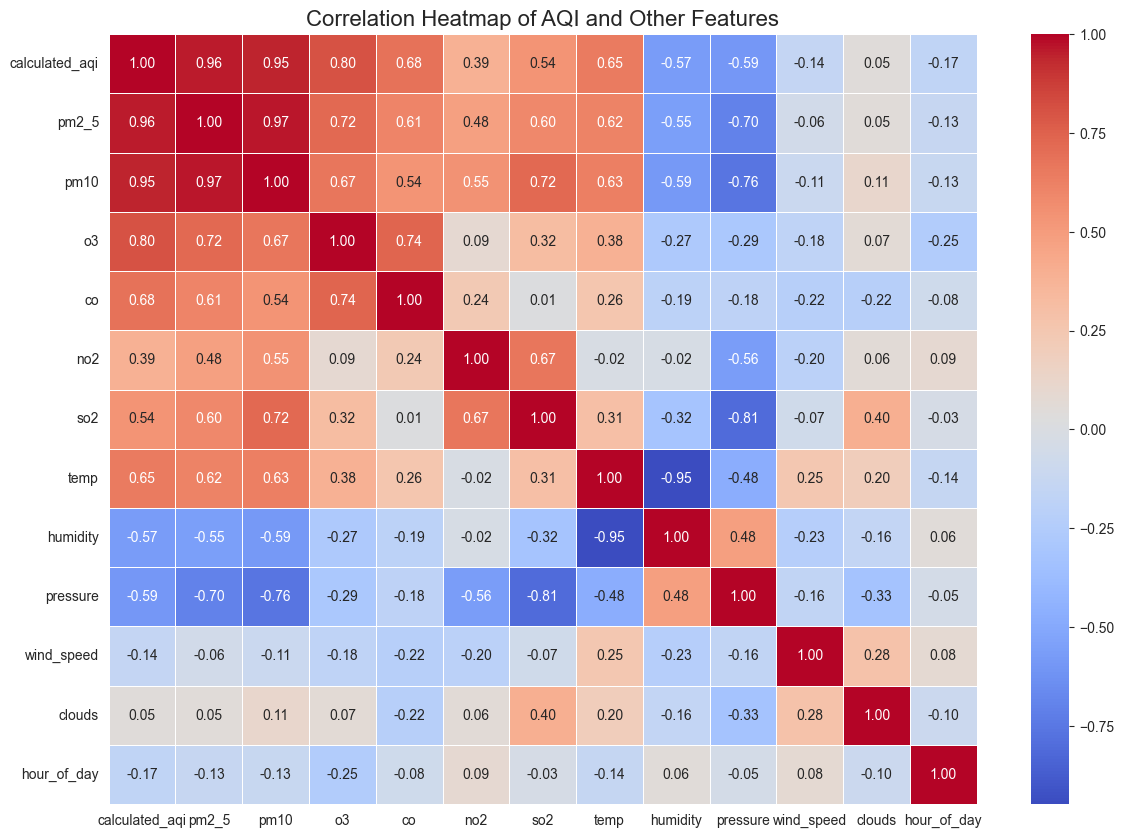

In [13]:
# Select only the numerical features for the correlation matrix
numerical_features = [
    'calculated_aqi', 'pm2_5', 'pm10', 'o3', 'co', 'no2', 'so2',
    'temp', 'humidity', 'pressure', 'wind_speed', 'clouds', 'hour_of_day'
]

# Calculate the correlation matrix
corr_matrix = df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of AQI and Other Features', fontsize=16)
plt.show()

Generating pairplot... (this may take a moment)


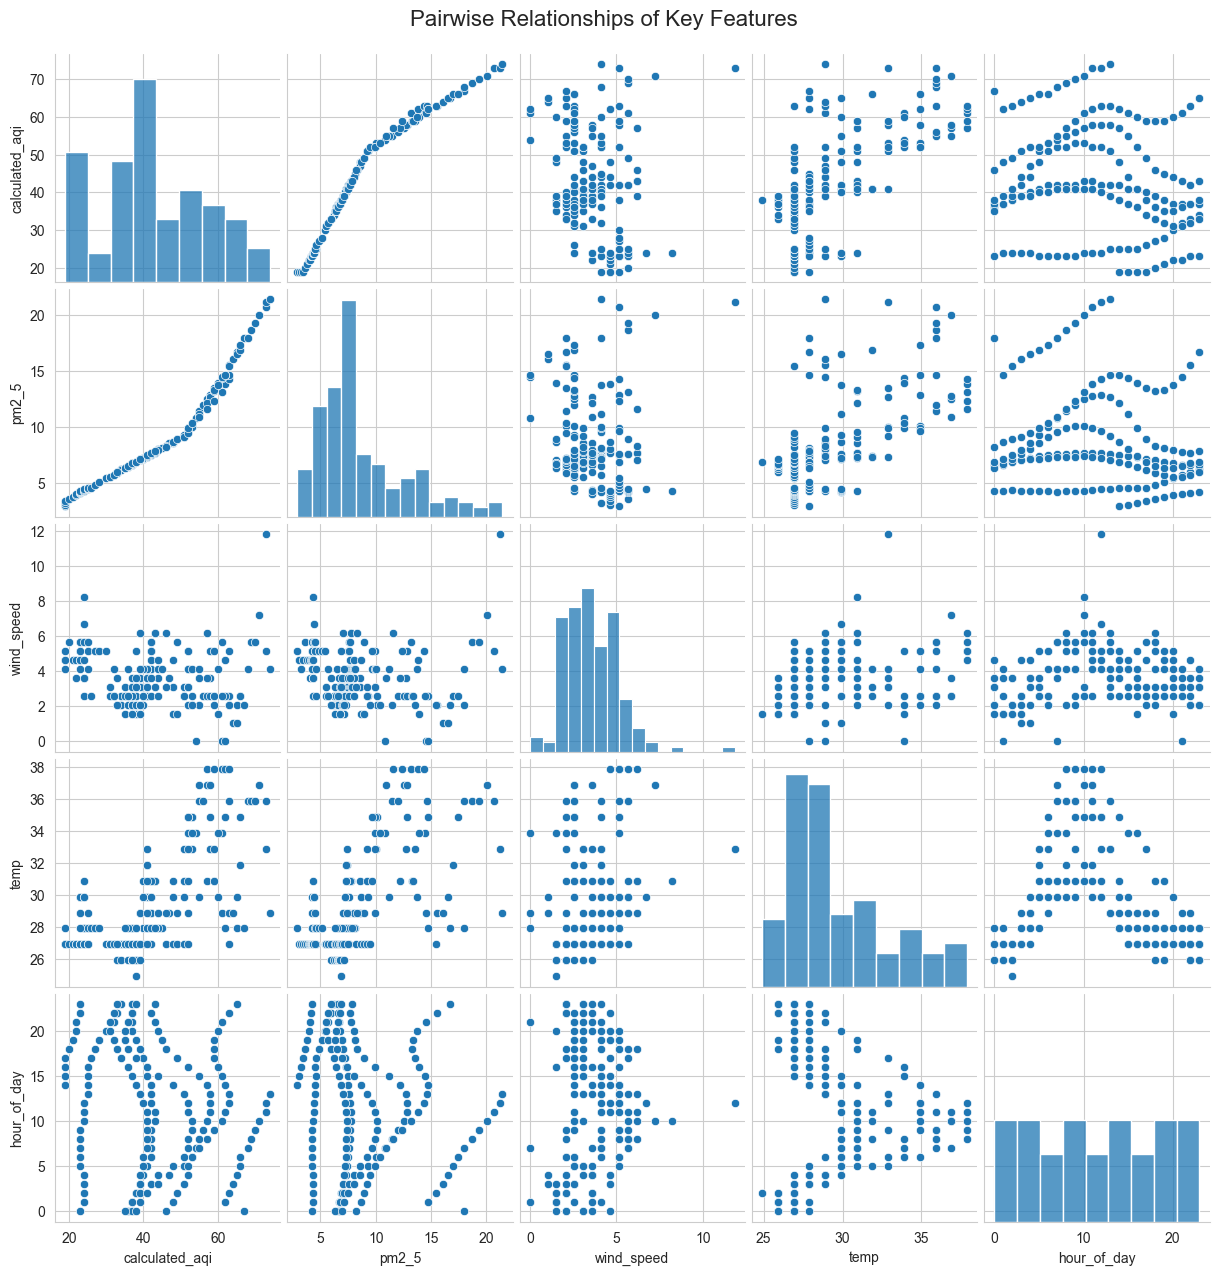

In [14]:
# Select a few key features for a pairplot
key_features = ['calculated_aqi', 'pm2_5', 'wind_speed', 'temp', 'hour_of_day']

print("Generating pairplot... (this may take a moment)")
sns.pairplot(df[key_features].dropna())
plt.suptitle('Pairwise Relationships of Key Features', y=1.02, fontsize=16)
plt.show()

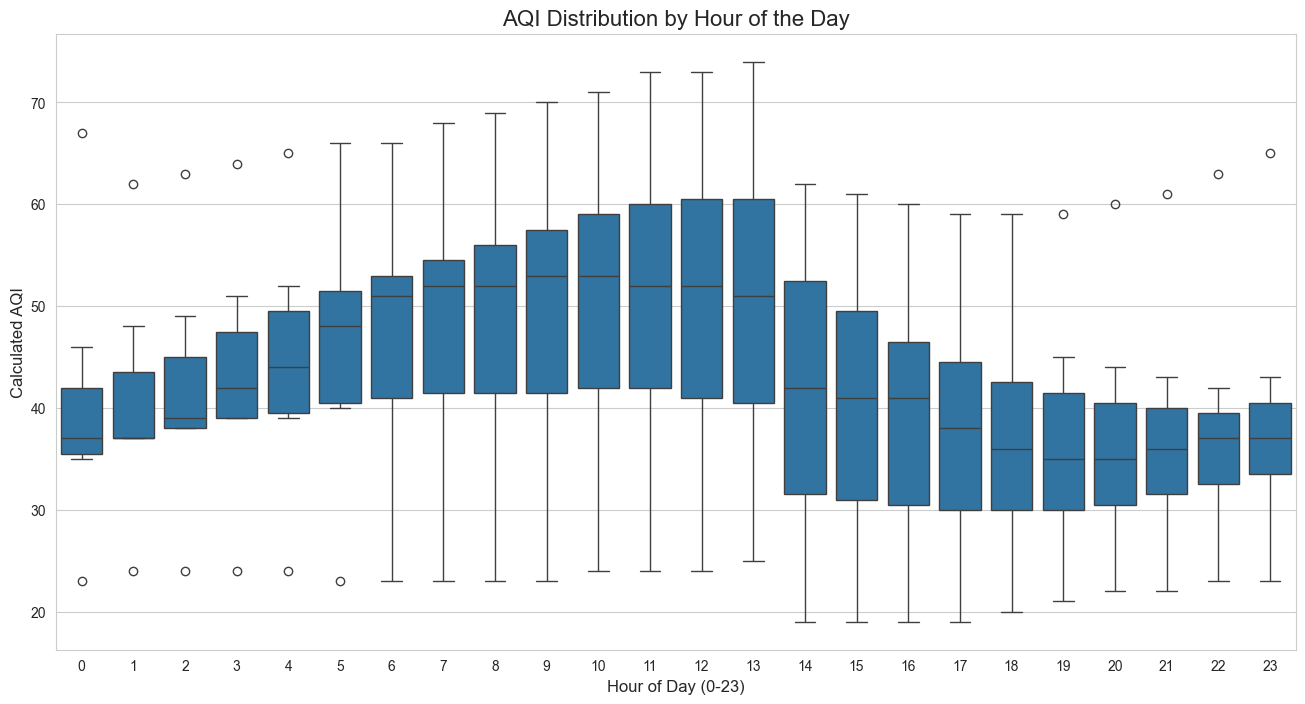

In [15]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='hour_of_day', y='calculated_aqi', data=df)
plt.title('AQI Distribution by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Calculated AQI', fontsize=12)
plt.show()

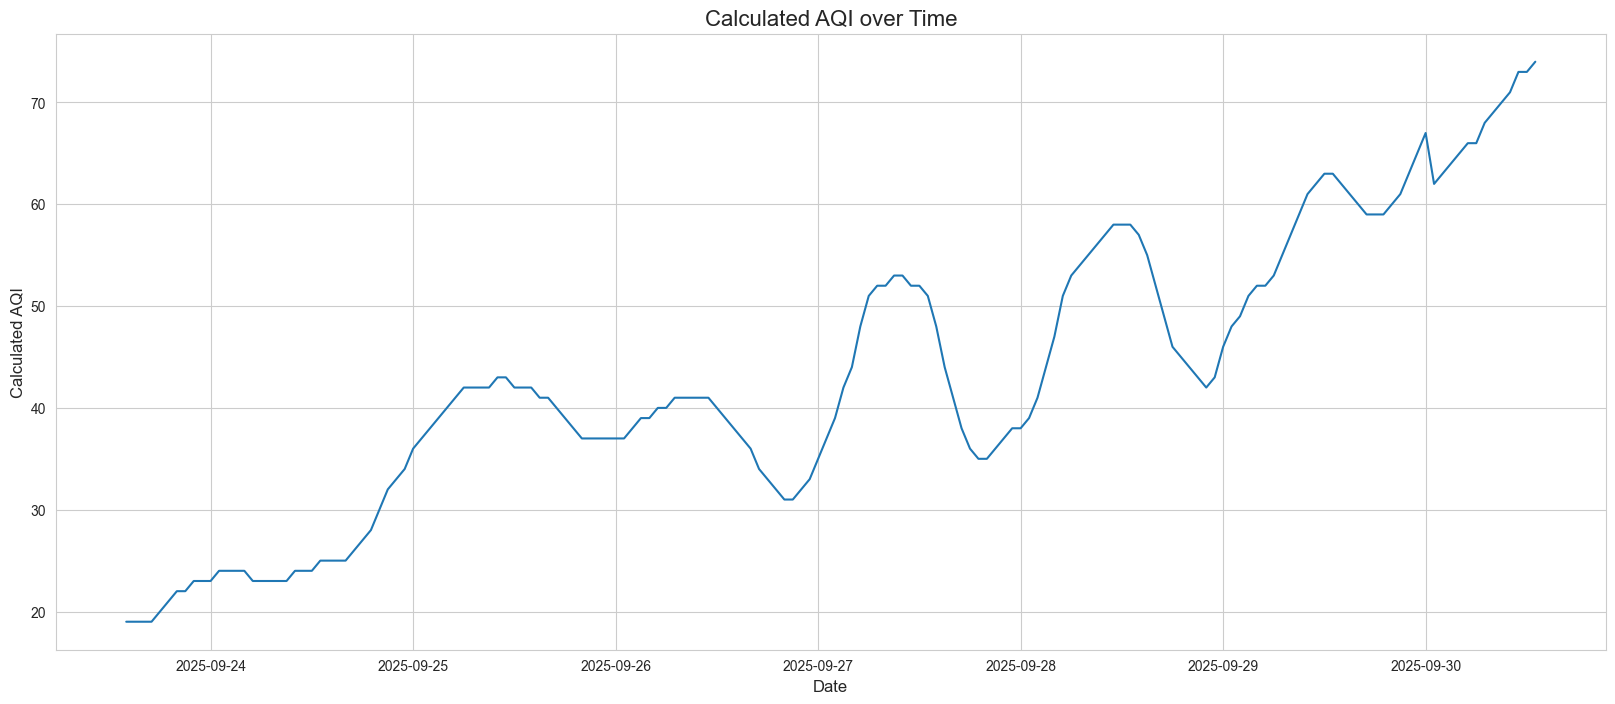

In [16]:
plt.figure(figsize=(20, 8))
sns.lineplot(x='timestamp_utc', y='calculated_aqi', data=df)
plt.title('Calculated AQI over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Calculated AQI', fontsize=12)
plt.show()

In [17]:
features = ['pm2_5',
    'pm10',
    'o3',
    'temp',
    'hour_of_day', 'calculated_aqi']

df_ml = df[features]

In [18]:
df_ml.head()

,pm2_5,pm10,o3,temp,hour_of_day,calculated_aqi
0,2.93,9.99,41.31,27.9,14,19
1,3.10,10.70,41.05,26.9,15,19
2,3.27,11.33,40.53,26.9,16,19
3,3.44,11.94,40.09,26.9,17,19
4,3.63,12.61,39.62,26.9,18,20


In [19]:
X = df_ml.drop("calculated_aqi", axis=1)
y = df_ml["calculated_aqi"]

# APPROCH ONE 

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
# Linear models are sensitive to feature scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (134, 5)
Test set shape: (34, 5)


In [22]:
# 1. Initialize models
models = {
    # --- Basic Linear Models ---
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),

    # --- Non-Linear Models ---
    'K-Neighbors Regressor (KNN)': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor (SVR)': SVR(kernel='rbf', C=10.0),

    # --- Ensemble Models (Often most powerful) ---
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 2. Train and evaluate
results = []
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'R² Score': r2, 'MAE': mae, 'RMSE': rmse})

# 3. Display results
results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Evaluation Results (with Data Leakage) ---")
display(results_df)

--- Model Evaluation Results (with Data Leakage) ---


,R² Score,MAE,RMSE
Model,,,
Linear Regression,0.962318,2.200666,2.652947
Ridge Regression,0.962329,2.208305,2.652567
Lasso Regression,0.962359,2.209150,2.651486
ElasticNet,0.961607,2.257198,2.677852
K-Neighbors Regressor (KNN),0.983472,1.505882,1.757003
Support Vector Regressor (SVR),0.995965,0.672889,0.868154
Random Forest,0.999079,0.239412,0.414828
Gradient Boosting,0.999102,0.199912,0.409534


# 2nd Approch

In [23]:
X_forecast = df[features]

# 2. Create the future target
PREDICTION_HORIZON = 3 # 3 hours
target_name = 'target_aqi_next_3h'
y_forecast = df['calculated_aqi'].shift(-PREDICTION_HORIZON).rename(target_name)

# 3. Combine and clean
# We must drop rows at the end that don't have a target (from shifting)
final_df = X_forecast.join(y_forecast, rsuffix='_target')
final_df = final_df.dropna()

# 4. Re-define X and y
X = final_df[features].drop("calculated_aqi", axis=1)
y = final_df[target_name] # This is our target column

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (132, 5)
Test set shape: (33, 5)


In [25]:
# 1. Initialize models
models = {
# --- Basic Linear Models ---
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),

    # --- Non-Linear Models ---
    'K-Neighbors Regressor (KNN)': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor (SVR)': SVR(kernel='rbf', C=10.0),

    # --- Ensemble Models (Often most powerful) ---
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# 2. Train and evaluate
results = []
trained_models = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model # Save the trained model
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'R² Score': r2, 'MAE': mae, 'RMSE': rmse})

# 3. Display results
results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Evaluation Results (Forecasting) ---")
display(results_df.round(3))

--- Model Evaluation Results (Forecasting) ---


,R² Score,MAE,RMSE
Model,,,
Linear Regression,0.964,2.115,2.761
Ridge Regression,0.965,2.089,2.748
Lasso Regression,0.965,2.055,2.743
ElasticNet,0.965,2.015,2.745
K-Neighbors Regressor (KNN),0.985,1.352,1.790
Support Vector Regressor (SVR),0.984,1.289,1.854
Random Forest,0.984,1.298,1.850
Gradient Boosting,0.985,1.350,1.768


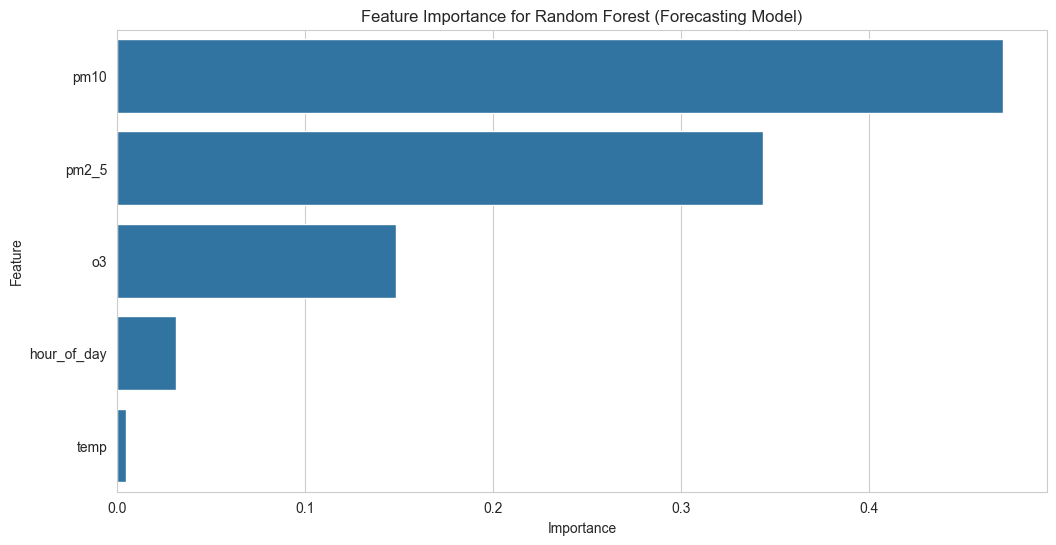

In [26]:
# Get the trained Random Forest model
rf_model = trained_models['Random Forest']

# Get importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance for Random Forest (Forecasting Model)')
plt.show()